In [47]:
from utils.analysis.analyzer import *
import re
from nltk.tokenize import sent_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/soumyajit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [164]:
# file_paths = ["../../US_climate_change_policy.pdf", "../../National_sustainabilyt_mission.pdf", "../../UKEF_Climate_Change_Strategy_2021.pdf"]
# file_paths = ["../../National_sustainabilyt_mission.pdf"]
file_paths = ["../../UKEF_Climate_Change_Strategy_2021.pdf"]
# file_paths = ["../../US_climate_change_policy.pdf"]

documents = []
for file_path in file_paths:
    text = read_pdf(file_path, return_list=False)
    documents.append(text)

In [101]:
# NEWS
with open("../dev/full_news_1.json", "r") as f:
    news = json.load(f)
    documents_ = [n["article"] for n in news]

with open("../lookup/health_news.json", "r") as f:
    news = json.load(f)
    documents = [documents_[n["news_idx"]] for n in news]

documents = documents_


#### Model Building

In [102]:
sentences = sent_tokenize("\n\n".join(documents))
print(len(sentences))


180600


In [103]:
# idx = 12
# len(sentences[idx].split())

sentences_ = []
for sentence in sentences:
    if len(sentence.split()) > 5 and not sentence.endswith("?"):
        sentences_.append(sentence)

print(len(sentences_))

165009


In [104]:
docs = sentences_.copy()

import nltk
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet')

# Split the documents into tokens, remove links and non-alphanumeric characters
import re
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

for idx in range(len(docs)):
    # Remove links
    docs[idx] = re.sub(r'http\S+|www.\S+', '', docs[idx])
    
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    
    # Remove non-alphanumeric characters and tokenize
    docs[idx] = tokenizer.tokenize(re.sub(r'\W', ' ', docs[idx]))

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

# Remove stopwords
docs = [[token for token in doc if token not in stopwords.words('english')] for doc in docs]

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/soumyajit/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [105]:
lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

In [106]:
dictionary = Dictionary(docs)
corpus = [dictionary.doc2bow(doc) for doc in docs]


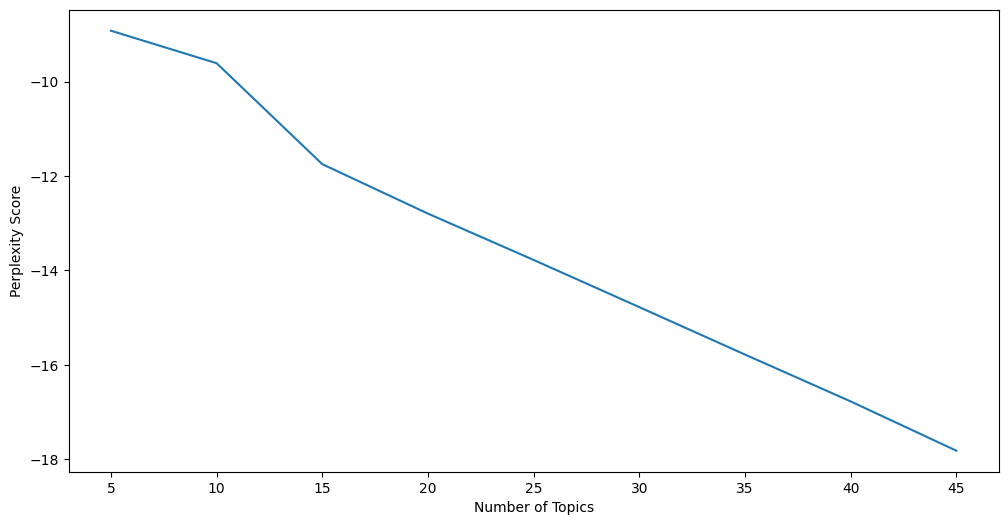

In [107]:
train_corpus = corpus[:int(len(corpus)*0.8)]
valid_corpus = corpus[int(len(corpus)*0.8):]

perplexity_values = []
num_topics_list = range(5, 50, 5)

for num_topics in num_topics_list:
    model = LdaModel(corpus=train_corpus, id2word=dictionary, num_topics=num_topics)
    perplexity_values.append(model.log_perplexity(valid_corpus))

plt.figure(figsize=(12, 6))
plt.plot(num_topics_list, perplexity_values)
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity Score")
plt.show()

In [108]:
model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=15)

In [73]:
num_topics_list[-1]

45

In [74]:
def print_topics(topics):
    topics_ls = []
    for topic in topics:
        words = topic[1].split("+")
        topic_words = [word.split("*")[1].replace('"', '').strip() for word in words]
        topics_ls.append(topic_words)
    for i, topic in enumerate(topics_ls):
        print(f"Topic_{i+1}:", ' '.join(topic))

def get_topics(topics):
    topics_ls = []
    for topic in topics:
        words = topic[1].split("+")
        topic_words = [word.split("*")[1].replace('"', '').strip() for word in words]
        topics_ls.append(topic_words)
    return topics_ls

# def calculate_topic_similarity(topics):
#     similarity_scores = []
#     for i in range(len(topics)):
#         for j in range(i+1, len(topics)):
#             similarity_score = len(set(topics[i]).intersection(set(topics[j])))/len(set(topics[i]).union(set(topics[j])))
#             similarity_scores.append(similarity_score)
#     return similarity_scores

def calculate_topic_similarity_matrix(topics):
    n = len(topics)
    similarity_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i, n):
            if i == j:
                similarity_matrix[i][j] = 1.0
            else:
                similarity_score = len(set(topics[i]).intersection(set(topics[j]))) / len(set(topics[i]).union(set(topics[j])))
                similarity_matrix[i][j] = similarity_score
                similarity_matrix[j][i] = similarity_score
    
    return similarity_matrix

topics = model.print_topics(num_words=30)
topics_ = get_topics(model.print_topics(num_words=30))
print_topics(topics)
similarity_scores = calculate_topic_similarity_matrix(topics_)
print(len(topics_))
# topics
# for topic in topics:
#     print(f"Topic_{topic[0]}: {topic[1]}\n")


Topic_1: energy india fossil renewable fuel coal power community climate across area urban also clean green sector need rural non phase said wage solution plant building water government city company transport
Topic_2: temperature year degree month celsius average last day march april india record every industrial view recorded pre june enable since said high maximum level imd meteorological summer heatwave delhi still
Topic_3: climate cooling change global heat extreme warming event weather health impact emission wave need human time demand rise one urban risk report world india take livelihood even daily say scientist
Topic_4: climate india change country action need nation community global policy solution environment developing business health challenge growth energy help said development financing public financial issue collective government responsibility resilient sustainable
Topic_5: india region temperature normal global country el ndc area brunt time begin record climate stati

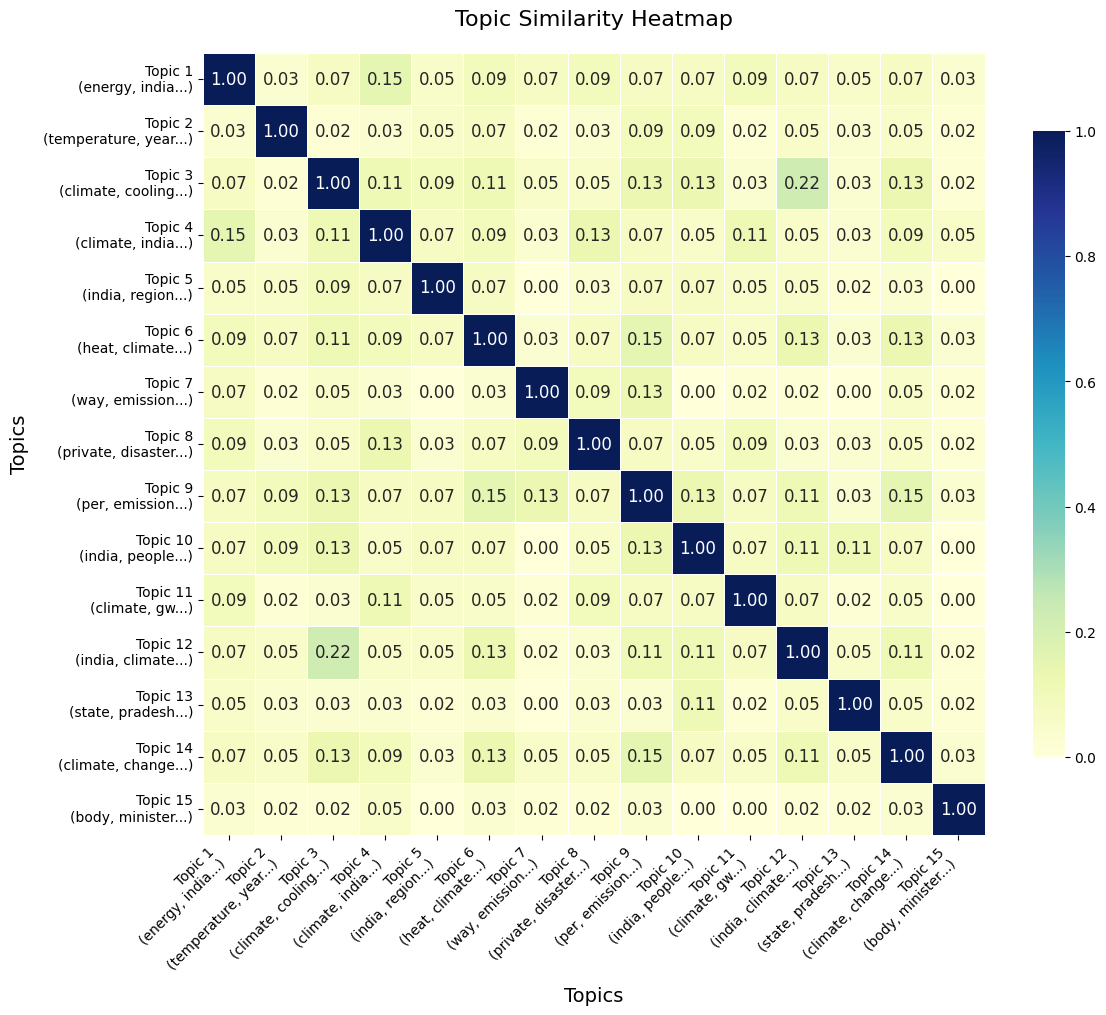

In [75]:
# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create heatmap with improved aesthetics
sns.heatmap(similarity_scores, 
            annot=True, 
            cmap="YlGnBu", 
            vmin=0, 
            vmax=1, 
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": .8},
            fmt=".2f",
            annot_kws={"size": 12})

# Customize the plot
plt.title("Topic Similarity Heatmap", fontsize=16, pad=20)
plt.xlabel("Topics", fontsize=14, labelpad=10)
plt.ylabel("Topics", fontsize=14, labelpad=10)

# Add topic labels with more descriptive names
topic_labels = [f"Topic {i+1}\n({', '.join(topics_[i][:2])}...)" for i in range(len(topics_))]
plt.xticks(np.arange(len(topics_)) + 0.5, topic_labels, rotation=45, ha='right', fontsize=10)
plt.yticks(np.arange(len(topics_)) + 0.5, topic_labels, rotation=0, va='center', fontsize=10)

# Adjust layout and display
plt.tight_layout()
plt.show()


In [76]:
df = pd.DataFrame()
for i, topic in enumerate(topics):
    words = topic[1].split("+")
    topic_words = [word.split("*")[1].replace('"', '').strip() for word in words]
    topic_weights = [float(word.split("*")[0]) for word in words]
    df[f"Topic_{i}"] = topic_words
    df[f"Topic_{i}_weights"] = topic_weights

In [77]:
# df = df[[f"Topic_{i}" for i in range(len(topics))] + [f"Topic_{i}_weights" for i in range(len(topics))]]
new_ordering = []
for i in range(len(topics)):
    new_ordering.append(f"Topic_{i}")
    new_ordering.append(f"Topic_{i}_weights")

df = df[new_ordering]

In [78]:
df.to_csv("topics_NEWS_HEALTH.csv", index=False)

#### Inference

In [19]:
# For each doc in documents split the text into sentences and find topic distribution for each sentence
tokenizer = RegexpTokenizer(r'\w+')

# Split the documents into sentences
sentences = [sent_tokenize(doc) for doc in documents]
doc_sentences = [[None] * len(sentences[idx]) for idx in range(len(sentences))]

for idx in range(len(sentences)):
    for ind in range(len(sentences[idx])):
        # Remove links -> convert to lowercase -> remove non-alphanumeric characters -> tokenize
        sentence = re.sub(r'http\S+|www.\S+', '', sentences[idx][ind])
        sentence = tokenizer.tokenize(re.sub(r'\W', ' ', sentence.lower()))
        # Remove numbers, but not words that contain numbers.
        sentence = [token for token in sentence if not token.isnumeric()]
        # Remove words that are only one character.
        sentence = [token for token in sentence if len(token) > 1]
        # Remove stopwords
        sentence = [token for token in sentence if token not in stopwords.words('english')]

        # Store in doc_sentences
        doc_sentences[idx][ind] = sentence

# Remove empty sentences & Create a version of sentences where the sentences corresponding to the empty sentences are removed
# Initialize new lists
filtered_doc_sentences = []
filtered_sentences = []

# Iterate over each document
for doc_idx, doc in enumerate(doc_sentences):
    temp_doc = []
    temp_sent = []
    for sent_idx, sentence in enumerate(doc):
        # If the sentence is not empty, add it to the temporary lists
        if sentence:
            temp_doc.append(sentence)
            temp_sent.append(sentences[doc_idx][sent_idx])
    # Add the temporary lists to the new lists
    filtered_doc_sentences.append(temp_doc)
    filtered_sentences.append(temp_sent)

In [20]:
# Lemmatize the tokens
lemmatizer = WordNetLemmatizer()
filtered_doc_sentences = [[[lemmatizer.lemmatize(token) for token in ls] for ls in doc] for doc in filtered_doc_sentences]

In [21]:
sentence_bow = [[dictionary.doc2bow(sentence) for sentence in doc] for doc in filtered_doc_sentences]
topic_distribution = [[model.get_document_topics(sentence) for sentence in doc] for doc in sentence_bow]

In [26]:
import pandas as pd
df = pd.DataFrame()

doc_country_map = {0: 'US', 2: 'UK', 1: 'IN'}

num_topics = len(topics_)
for i in range(len(topic_distribution)):
    for dist, sentence in zip(topic_distribution[i], filtered_sentences[i]):
        dist_dict = dict(dist)
        dist_dict['Sentence'] = sentence
        try:
            dist_dict['Doc_ID'] = doc_country_map[i]
        except:
            dist_dict['Doc_ID'] = 'NA'
        df_ = pd.DataFrame([dist_dict])
        df = pd.concat([df, df_], ignore_index=True)

df.rename(columns={i: f'Topic_{i}' for i in range(num_topics)}, inplace=True)
df = df[['Doc_ID', 'Sentence'] + [f'Topic_{i}' for i in range(num_topics)]]


In [27]:
# Compute mean and standard deviation for each topic (for each topic, across all documents)

# Compute mean for each topic
topic_means = df[[f'Topic_{i}' for i in range(num_topics)]].mean()

# Compute standard deviation for each topic
topic_stds = df[[f'Topic_{i}' for i in range(num_topics)]].std()

print("Topic Means: \n", topic_means)
print("Topic Standard Deviations: \n", topic_stds)

Topic Means: 
 Topic_0     0.180050
Topic_1     0.128435
Topic_2     0.131793
Topic_3     0.154437
Topic_4     0.193795
Topic_5     0.135330
Topic_6     0.126271
Topic_7     0.163504
Topic_8     0.114591
Topic_9     0.133426
Topic_10    0.239660
Topic_11    0.123085
Topic_12    0.109840
Topic_13    0.210884
Topic_14    0.115600
dtype: float32
Topic Standard Deviations: 
 Topic_0     0.181003
Topic_1     0.155346
Topic_2     0.156106
Topic_3     0.169723
Topic_4     0.192979
Topic_5     0.152083
Topic_6     0.142895
Topic_7     0.171547
Topic_8     0.135898
Topic_9     0.152214
Topic_10    0.232956
Topic_11    0.143344
Topic_12    0.129823
Topic_13    0.206712
Topic_14    0.137412
dtype: float32


In [28]:
# Replace NaN values with 0
df.fillna(0, inplace=True)

In [29]:
# Compute mean for each topic
topic_means = df[[f'Topic_{i}' for i in range(num_topics)]].mean()

for i in range(num_topics):
    df[f'TS_{i}'] = df[f'Topic_{i}'].apply(lambda x: 1 if x >= topic_means[f'Topic_{i}'] else 0)

In [30]:
# Create a new column 'Sentence_ID' where each sentence in a document gets a unique ID
df['Sentence_ID'] = df.groupby('Doc_ID').cumcount() + 1

# Update 'Sentence_ID' to include 'Doc_ID'
df['Sentence_ID'] = df['Doc_ID'] + '_' + df['Sentence_ID'].astype(str)

In [31]:
df = df[['Doc_ID', 'Sentence_ID', 'Sentence'] + [f'Topic_{i}' for i in range(num_topics)] + [f'TS_{i}' for i in range(num_topics)]]

In [32]:
df.to_csv('topic_modeling_results_AGRI.csv', index=False)

In [34]:
df['Doc_ID'] = 'NA'
df['Sentence_ID'] = df['Sentence_ID'].apply(lambda x: x.split('_')[1])

In [35]:
df

,Doc_ID,Sentence_ID,Sentence,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,...,TS_5,TS_6,TS_7,TS_8,TS_9,TS_10,TS_11,TS_12,TS_13,TS_14
0,NA,1,"The natural biomolecules, available in liquid ...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,1,0,1,0,1,0,0,0
1,NA,2,(File Express photo)\nThe rising instances of ...,0.000000,0.165265,0.000000,0.149922,0.000000,0.128266,0.000000,...,1,0,0,0,0,1,0,0,1,0
2,NA,3,Such inclement weather not only damages standi...,0.287049,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,1,1,0,0,0
3,NA,4,In order to help farmers better deal with the ...,0.357212,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,1
4,NA,5,“A sudden change in weather or significant flu...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26111,NA,26033,But what will be the consequence of continued ...,0.000000,0.000000,0.000000,0.183849,0.000000,0.000000,0.000000,...,0,0,0,1,1,0,1,0,0,0
26112,NA,26034,It is unclear if all the countries in West Asi...,0.000000,0.000000,0.000000,0.476409,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
26113,NA,26035,Saudi Arabia appears to be strategising along ...,0.000000,0.000000,0.000000,0.000000,0.209113,0.444524,0.000000,...,1,0,0,0,0,0,1,0,0,1
26114,NA,26036,It is abundantly clear that a narrow-minded vi...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,1,1,1,1,0,1,0


In [ ]:
df.to_

#### Better Context Generation

In [36]:
def filter_and_sort(df: pd.DataFrame, topic_id: int, threshold: float = 0.5):
    # Filter the dataframe based on the threshold
    df_ = df[df[f'Topic_{topic_id}'] >= threshold]

    return df_

def group_and_fill(df_full: pd.DataFrame, df_filtered: pd.DataFrame, topic_id: int, threshold: int = 5):
    # Get the indices of the filtered dataframe
    indices = df_filtered.index.tolist()

    # Fill intermediate indices based on the threshold
    for i in range(len(indices)-1):
        if indices[i+1] - indices[i] <= threshold:
            df_filtered = pd.concat([df_filtered, df_full.iloc[indices[i]+1:indices[i+1]]])
    
    df_filtered = df_filtered.sort_index()
    return df_filtered

def get_better_context(df: pd.DataFrame, topic_id: int, filter_threshold: float = 0.5, group_threshold: int = 5):
    df_filtered = filter_and_sort(df, topic_id)
    df_grouped = group_and_fill(df, df_filtered, topic_id)

    context = df_grouped['Sentence'].tolist()

    return df_grouped, '\n\n'.join(context)


    

In [37]:
df_grouped, context = get_better_context(df, 0, group_threshold=10)

In [38]:
print(context)

With the use of these specialised bio-molecules, the crop growth could be enhanced to 70 per cent, even in adverse weather conditions,” explained Karandikar.

"We understand why Punjab farmers are angry over doing away with state-run wholesale buyers and markets that guaranteed a minimum support price," he added.

But instead of relying on the government for help, farmers in Marathwada have brought in changes to crop management, leading to better crop yields, improved food security and increased resilience to adverse effects of climate change.

[1] It is responsible for both food and nutritional security and is key to efforts towards alleviating poverty and reducing inequality.

The Price of Rice
Rice is the staple food for more than 65 percent of the Indian population and contributes 40 percent of total food grain production in India.

[6] It occupies a central role in Indian agriculture as it provides food and livelihood security to a large proportion of the rural population.

In 201

In [191]:
contexts = []
for i in range(num_topics):
    _, context = get_better_context(df, i, group_threshold=10)
    contexts.append(context)

#### LLM Categorizing the Topics

In [39]:
from dotenv import load_dotenv
from utils.analysis.analyzer import *

In [40]:
load_dotenv(".env")

True

In [41]:
question = "Based on the context give a topic name and a summary of the topic in json format."
output = analyze_doc(context, question)

BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16385 tokens. However, your messages resulted in 33328 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}

In [195]:
output

{'topic': 'Climate Change Strategy Implementation',
 'summary': 'This topic focuses on the implementation of the Climate Change Strategy within the organization, including decision-making processes, change management, learning and development of staff, governance structure, and enablers for successful implementation.'}

In [196]:
outputs = []
for context in contexts:
    output = analyze_doc(context, question)
    outputs.append(output)

In [197]:
outputs

[{'topic': 'Climate Change Strategy Implementation',
  'summary': 'The implementation of the Climate Change Strategy involves enhancing governance, decision-making processes, and engagement with NGOs and civil society to address climate-related risks and opportunities. This includes establishing climate-related responsibilities at senior management and Board levels, publishing governance structures, and transparent reporting on TCFD commitments.'},
 {'topic': 'Strategic Pillars and Enablers',
  'summary': 'The strategic pillars and enablers focus on increasing support for clean growth and climate adaptation, reducing portfolio greenhouse gas emissions, understanding and mitigating climate-related financial risks, transparency and disclosure, and providing international leadership on climate change. This includes setting interim targets for net zero greenhouse gas emissions by 2050, developing green products, expanding staffing for clean growth transactions, and taking climate change ri

In [198]:
with open("Topic_Summary_UK.json", "w") as f:
    json.dump(outputs, f, indent=4)

In [63]:
question = "The context is the output of an unsupervised topic extaction method. Based on the context give a topic name and a summary of the topic in json format."
# output = analyze_doc(context, question)
outputs = []
for topic in topics_:
    context = ' '.join(topic)
    output = analyze_doc(context, question)
    outputs.append(output)

In [79]:
with open("Topic_Summary_NEWS_HEALTH.json", "w") as f:
    json.dump(outputs, f, indent=4)

In [98]:
def json_to_csv(json_file: str):
    with open(json_file, "r") as f:
        data = json.load(f)

    df = pd.DataFrame()
    for d in data:
        df_ = pd.DataFrame({"topic": d["topic"], "summary": d["summary"]}, index=[0])
        df = pd.concat([df, df_], ignore_index=True)

    df.to_csv(json_file.replace(".json", ".csv"), index=False)
    return df
    

In [99]:
df_health = json_to_csv("Topic_Summary_NEWS_HEALTH.json")
df_bio = json_to_csv("Topic_Summary_NEWS_BIODIVERSITY.json")

In [100]:
df_agri = json_to_csv("Topic_Summary_NEWS_AGRI.json")